In [1]:
from matplotlib import pyplot as plt
from whar_datasets.adapters.sampler import WHARSampler
from whar_datasets.support.getter import WHARDatasetID, get_whar_cfg

In [2]:
cfg = get_whar_cfg(WHARDatasetID.UCI_HAR)
sampler = WHARSampler(cfg, override_cache=False)

Creating config hash...
Checking download...
Download exists.
Checking sessions...
Sessions exist.
Validating common format...
[########################################] | 100% Completed | 755.38 ms
Common format validated.
Checking windowing...
Loading config hash...
Windowing exists.
subject_ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
activity_ids: [0 1 2 3 4 5]


In [3]:
sampler.prepare(scv_group_index=0)

Postprocessing...


Loading windows: 100%|██████████| 9499/9499 [00:07<00:00, 1299.88it/s]


Getting normalization parameters...
Loading config hash...
Creating normalization parameters hash...
Loading normalization parameters hash...


Loading samples: 100%|██████████| 9499/9499 [00:02<00:00, 4064.40it/s]


In [4]:
weights = sampler.get_class_weights(sampler.train_indices)
print(weights)

{2: 0.8292814459578982, 0: 0.8537360102227118, 1: 0.9104131038433669, 3: 1.002926213702739, 5: 1.1338565288075355, 4: 1.2697866974657486}


torch.Size([1]) torch.Size([1, 128, 9])


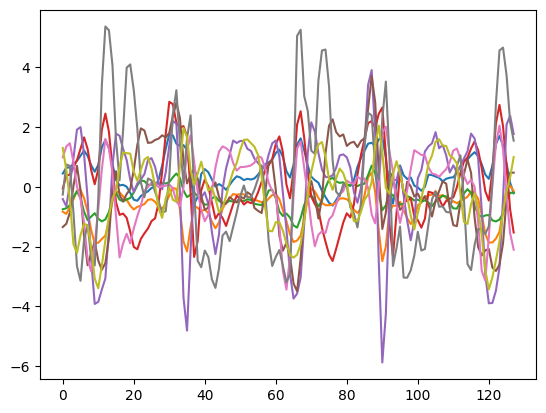

In [5]:
y, x = sampler.sample(1, sampler.train_indices, subject_id=5, activity_id=3, seed=None)
print(y.shape, x.shape)

plt.plot(x[0])
plt.show()

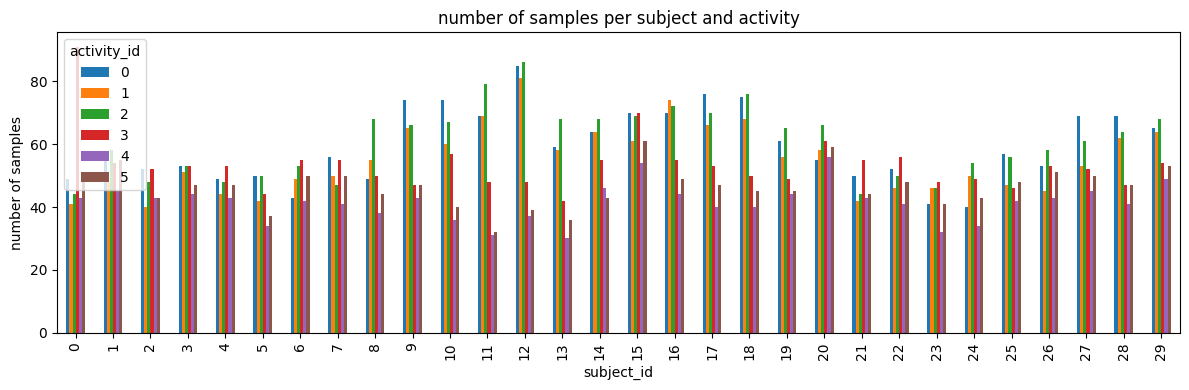

In [7]:
sampler.plot_indices_statistics(sampler.train_indices + sampler.test_indices)

In [6]:
subset = sampler.window_metadata.iloc[sampler.train_indices]

# Merge with session_metadata to get subject_id info
merged = subset.merge(
    sampler.session_metadata[["session_id", "subject_id", "activity_id"]],
    on="session_id",
    how="left",
)

subject_ids = merged["subject_id"].unique().tolist()
print(subject_ids)
subject_ids = subject_ids[:4]

print(merged.value_counts("activity_id"))

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
activity_id
2    1571
0    1526
1    1431
3    1299
5    1149
4    1026
Name: count, dtype: int64


In [7]:
subject_map = {}

for sub in subject_ids:
    _, samples = sampler.sample(20, sampler.train_indices, activity_id=1, subject_id=5)
    subject_map[sub] = samples  # (32, 128, 9)


/Users/maxburzer/whar-datasets/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


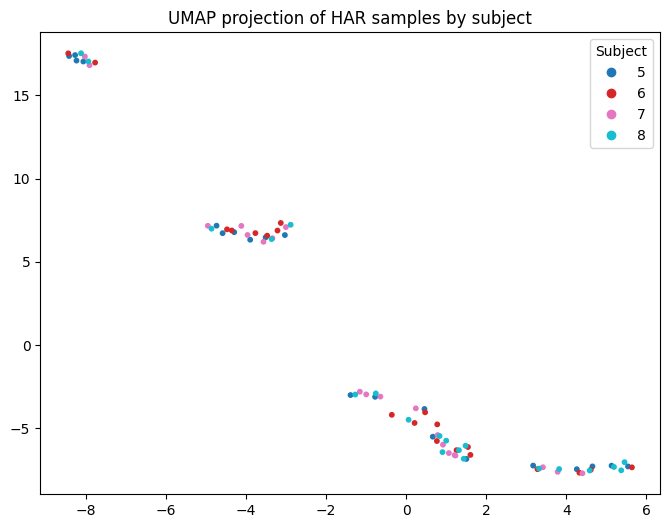

In [8]:
import numpy as np
import umap
import matplotlib.pyplot as plt

# Assuming subject_map[sub] = array of shape (32, 128, 9)

X_list = []
y_list = []

for sub, samples in subject_map.items():
    # Flatten each sequence from (128, 9) → (1152,)
    flat_samples = samples.reshape(samples.shape[0], -1)

    X_list.append(flat_samples)
    y_list.extend([sub] * samples.shape[0])  # label with subject id

# Stack into single dataset
X = np.vstack(X_list)  # shape (num_subjects * 32, 1152)
y = np.array(y_list)

# Run UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

# Plot with subjects in different colors
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap="tab10", s=10)
plt.legend(*scatter.legend_elements(), title="Subject")
plt.title("UMAP projection of HAR samples by subject")
plt.show()